In [1]:
# import dependencies
import pandas as pd
import tensorflow as tf

In [2]:
# initialize spark
import findspark
findspark.init()

In [3]:
# import dependencies
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import sklearn as skl

In [4]:
# initialize spark session
spark = SparkSession.builder.appName('SparkSQL').getOrCreate()

In [5]:
# use spark to read in csv to dataframe
spark.sparkContext.addFile('games_metadata_profile_2024_01.csv')
df = spark.read.csv(SparkFiles.get('games_metadata_profile_2024_01.csv'), header=True, inferSchema= True)

In [6]:
# create temporary view / table to use for queries
df.createOrReplaceTempView('chess')

In [7]:
# view dataframe
df.show()

+------+-----------------+-----+--------------------+----------+-------------------+---------------+--------+---------------+----------------+------------------+------------------+-----------------+--------------------+---------------+-----------+--------------------+--------+---------------+----------------+------------------+------------------+-----------------+--------------------+---------------+-----------+--------------------+----------+---+--------------------+-----------+------------+-------+
|GameID|            Event|Round|                Site|      Date|               Time|          White|WhiteElo|WhiteRatingDiff|White_is_deleted|White_tosViolation|White_profile_flag|  White_createdAt|White_playTime_total|White_count_all|White_title|               Black|BlackElo|BlackRatingDiff|Black_is_deleted|Black_tosViolation|Black_profile_flag|  Black_createdAt|Black_playTime_total|Black_count_all|Black_title|               Moves|TotalMoves|ECO|             Opening|TimeControl| Terminati

In [156]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all, TotalMoves,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [157]:
# drop null values
data.dropna(inplace=True)

In [158]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

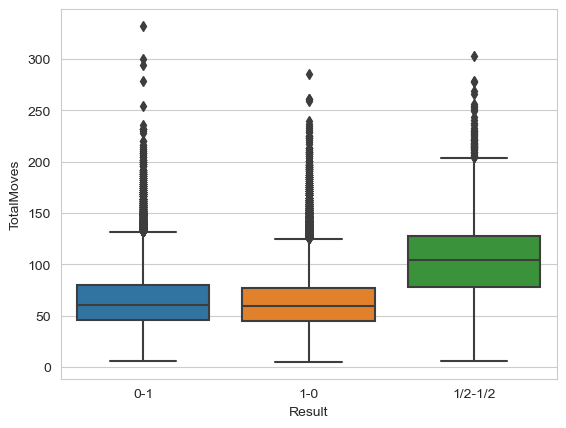

In [11]:
# create boxplot to explore difference between white and black victories with regard to total moves made
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['TotalMoves'])

(-10000000.0, 10000000.0)

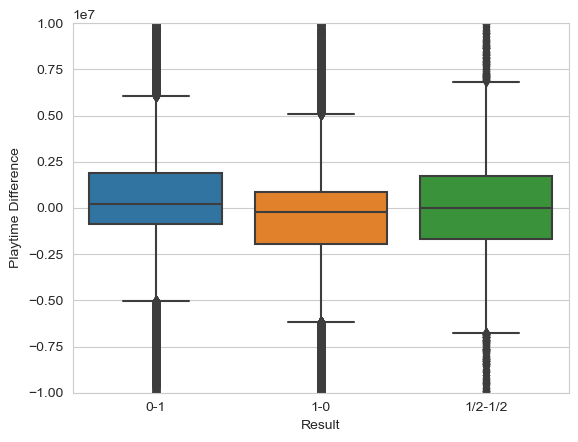

In [12]:
# create boxplot to explore difference between white and black victories with regard to difference in playtime
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Playtime Difference'])
ax.set_ylim(bottom = -10000000, top = 10000000)

(-30000.0, 30000.0)

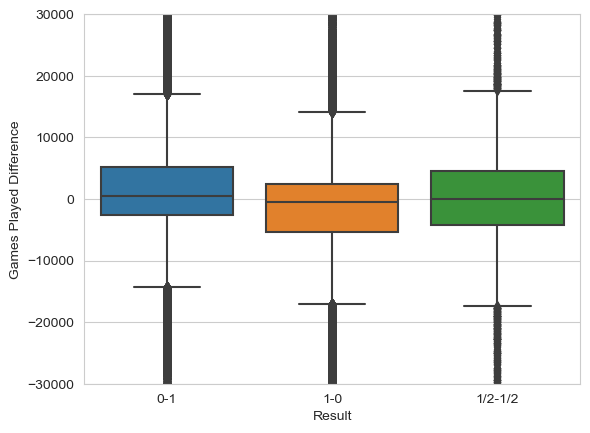

In [13]:
# create boxplot to explore difference between white and black victories with regard to number of games played
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Games Played Difference'])
ax.set_ylim(bottom = -30000, top = 30000)

(-200.0, 200.0)

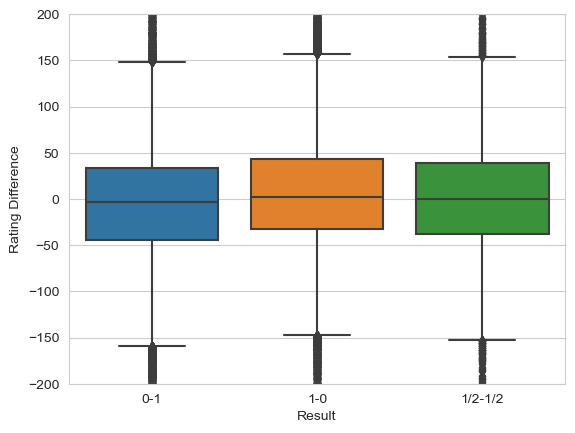

In [14]:
# create boxplot to explore difference between white and black victories with regard to difference in how the players are rated
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Rating Difference'])
ax.set_ylim(bottom = -200, top = 200)

(-600.0, 600.0)

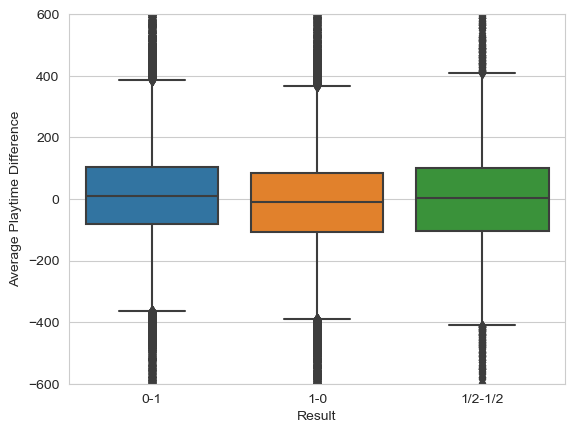

In [15]:
# create boxplot to explore difference between white and black victories with regard to average difference in playtime
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Average Playtime Difference'])
ax.set_ylim(bottom = -600, top = 600)

In [174]:
# drop features that are not new hyperparameters
data.drop(['WhiteElo','BlackElo','White_count_all','Black_count_all','White_playTime_total','Black_playTime_total'],axis=1,inplace=True)

## Logistic Regression

In [159]:
# assign features and target to X and y variables
y = data['Result']
X = pd.get_dummies(data.drop('Result', axis=1))
# split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [18]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# create an instance of logistic regression model and train model with training data
from sklearn.linear_model import LogisticRegression
linear = LogisticRegression(max_iter=1000)

linear.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=1000)

In [20]:
# view accuracy score and classification report based on logistic regression model
from sklearn.metrics import accuracy_score, classification_report
y_pred = linear.predict(X_test_scaled)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(classification_report(y_test,y_pred))

Accuracy Score: 0.5486458101269851
              precision    recall  f1-score   support

         0-1       0.54      0.39      0.45     14516
         1-0       0.55      0.73      0.63     15841
     1/2-1/2       0.26      0.05      0.08      1064

    accuracy                           0.55     31421
   macro avg       0.45      0.39      0.39     31421
weighted avg       0.54      0.55      0.53     31421



## Random Forest

In [21]:
# initiate a random forest model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [74]:
# dummy encode categorical variables and assign features and targets to X and y variables
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [316]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [317]:
# train the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [318]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [319]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [320]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.6016040227873078
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.67      0.57      0.62     14516
  White Wins       0.68      0.67      0.67     15841
        Draw       0.00      0.00      0.00      1064

   micro avg       0.67      0.60      0.64     31421
   macro avg       0.45      0.41      0.43     31421
weighted avg       0.65      0.60      0.62     31421
 samples avg       0.60      0.60      0.60     31421



c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [321]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(importances, X.columns), reverse=True)

[(0.19507156071721687, 'TotalMoves'),
 (0.14279263196713235, 'Playtime Difference'),
 (0.13946888783574055, 'Games Played Difference'),
 (0.132768463350627, 'Rating Difference'),
 (0.13144882239692643, 'Average Playtime Difference'),
 (0.12963849311032632, 'White Average Playtime'),
 (0.12881114062203056, 'Black Average Playtime')]

## Sequential NN Model

In [23]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 27011 (105.51 KB)
Trainable params: 27011 (105.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# compile the model
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
# fit the model with training data
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100


2946/2946 [==============================] - 3s 733us/step - loss: 0.7881 - accuracy: 0.5485
Epoch 2/100
2946/2946 [==============================] - 2s 707us/step - loss: 0.7787 - accuracy: 0.5610
Epoch 3/100
2946/2946 [==============================] - 2s 717us/step - loss: 0.7754 - accuracy: 0.5683
Epoch 4/100
2946/2946 [==============================] - 2s 738us/step - loss: 0.7734 - accuracy: 0.5709
Epoch 5/100
2946/2946 [==============================] - 2s 770us/step - loss: 0.7729 - accuracy: 0.5719
Epoch 6/100
2946/2946 [==============================] - 2s 792us/step - loss: 0.7717 - accuracy: 0.5736
Epoch 7/100
2946/2946 [==============================] - 2s 729us/step - loss: 0.7712 - accuracy: 0.5754
Epoch 8/100
2946/2946 [==============================] - 3s 1ms/step - loss: 0.7700 - accuracy: 0.5758
Epoch 9/100
2946/2946 [==============================] - 4s 1ms/step - loss: 0.7699 - accuracy: 0.5758
Epoch 10/100
2946/2946 [==============================] -

In [26]:
# Evaluate the model using the test data
model_loss, val_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {val_accuracy}")

982/982 - 1s - loss: 0.7937 - accuracy: 0.5697 - 616ms/epoch - 627us/step
Loss: 0.7937012910842896, Accuracy: 0.5697145462036133


In [69]:
# Getting predictions
predictions = nn.predict(X_test_scaled)

  1/982 [..............................] - ETA: 12s

982/982 [==============================] - 1s 561us/step


In [71]:
# Making predictions match format of y test
predictions_df = pd.DataFrame(predictions==predictions.max(axis=1,keepdims=1)).astype(float).replace({0:False, 1:True})

C:\Users\Ian\AppData\Local\Temp\ipykernel_23532\381289189.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions_df = pd.DataFrame(predictions==predictions.max(axis=1,keepdims=1)).astype(float).replace({0:False, 1:True})


In [75]:
# store the accuracy score
acc_score = accuracy_score(y_test, predictions_df)

In [76]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_df, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.5697145221348779
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.55      0.60      0.57     14516
  White Wins       0.59      0.58      0.59     15841
        Draw       0.21      0.01      0.01      1064

   micro avg       0.57      0.57      0.57     31421
   macro avg       0.45      0.40      0.39     31421
weighted avg       0.56      0.57      0.56     31421
 samples avg       0.57      0.57      0.57     31421



## Hyperparameter Tuning

In [325]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid','softmax','swish'])
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=512,
        step=5), activation=activation, input_dim=len(X_train.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 8)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=512,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

    # Compile the model
    nn_model.compile(loss="CategoricalCrossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [326]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    overwrite=True)

In [327]:
# Running the tuner
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 01m 56s]
val_accuracy: 0.5763979554176331

Best val_accuracy So Far: 0.5787212252616882
Total elapsed time: 00h 37m 56s


In [328]:
# The best 3 hyperparameter sets
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'relu', 'first_units': 441, 'num_layers': 6, 'units_0': 251, 'units_1': 96, 'units_2': 156, 'units_3': 396, 'units_4': 16, 'units_5': 121, 'units_6': 116, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018', 'units_7': 11}
{'activation': 'relu', 'first_units': 166, 'num_layers': 2, 'units_0': 236, 'units_1': 6, 'units_2': 221, 'units_3': 456, 'units_4': 386, 'units_5': 156, 'units_6': 281, 'units_7': 381, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0042'}
{'activation': 'relu', 'first_units': 256, 'num_layers': 2, 'units_0': 76, 'units_1': 281, 'units_2': 101, 'units_3': 36, 'units_4': 431, 'units_5': 216, 'units_6': 136, 'units_7': 196, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0050'}


In [329]:
# Accuracy and Loss of the best model
best_model = tuner.get_best_models()[0]
model_loss, val_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {val_accuracy}")

982/982 - 1s - loss: 0.7691 - accuracy: 0.5787 - 802ms/epoch - 817us/step
Loss: 0.769116997718811, Accuracy: 0.5787212252616882


## Binning Outliers in Rating Difference

In [160]:
# Creating bins for rating difference
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
# Cutting columns by bins
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

In [161]:
# view binned data
data['Rating Difference'].head()

0      (50, 150]
1    (-150, -50]
2       (-50, 0]
3       (-50, 0]
4       (-50, 0]
Name: Rating Difference, dtype: category
Categories (10, interval[int64, right]): [(-2000, -1000] < (-1000, -500] < (-500, -150] < (-150, -50] ... (50, 150] < (150, 500] < (500, 1000] < (1000, 2000]]

In [162]:
# dummy encode the categorical data and sort into target and features
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))

In [163]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [164]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [335]:
# initiate a random forest model
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [336]:
# train the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [337]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [338]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [339]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.5837497215238217
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.65      0.55      0.60     14516
  White Wins       0.66      0.65      0.65     15841
        Draw       0.00      0.00      0.00      1064

   micro avg       0.65      0.58      0.62     31421
   macro avg       0.43      0.40      0.42     31421
weighted avg       0.63      0.58      0.61     31421
 samples avg       0.58      0.58      0.58     31421



c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [340]:
# Calculating feature importance
importances = rf_model.feature_importances_
sorted(zip(importances, X.columns), reverse=True)

[(0.20417716258915353, 'TotalMoves'),
 (0.16008715376553523, 'Playtime Difference'),
 (0.15679306866432044, 'Games Played Difference'),
 (0.14858828998382126, 'Average Playtime Difference'),
 (0.14661640016872798, 'White Average Playtime'),
 (0.14642235984674798, 'Black Average Playtime'),
 (0.007563483583772837, 'Rating Difference_(-50, 0]'),
 (0.00738571955451873, 'Rating Difference_(0, 50]'),
 (0.005389051272143455, 'Rating Difference_(-150, -50]'),
 (0.004439173176373118, 'Rating Difference_(-500, -150]'),
 (0.004362699279370156, 'Rating Difference_(150, 500]'),
 (0.004288556761098735, 'Rating Difference_(50, 150]'),
 (0.0016191535146478657, 'Rating Difference_(500, 1000]'),
 (0.0016089741538236977, 'Rating Difference_(-1000, -500]'),
 (0.0004122208829182406, 'Rating Difference_(-2000, -1000]'),
 (0.0002465328030266965, 'Rating Difference_(1000, 2000]')]

In [165]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="relu")
)

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               5888      
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 3)                 195       
                                                                 
Total params: 30851 (120.51 KB)
Trainable params: 30851 (120.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [166]:
# Compile model: Categorical Crossentropy used because output data is categorical and not binary
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [167]:
# Fitting model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100


2946/2946 [==============================] - 3s 758us/step - loss: 0.7869 - accuracy: 0.5473
Epoch 2/100
2946/2946 [==============================] - 2s 769us/step - loss: 0.7733 - accuracy: 0.5683
Epoch 3/100
2946/2946 [==============================] - 2s 796us/step - loss: 0.7687 - accuracy: 0.5739
Epoch 4/100
2946/2946 [==============================] - 2s 784us/step - loss: 0.7662 - accuracy: 0.5752
Epoch 5/100
2946/2946 [==============================] - 2s 765us/step - loss: 0.7646 - accuracy: 0.5772
Epoch 6/100
2946/2946 [==============================] - 2s 778us/step - loss: 0.7628 - accuracy: 0.5782
Epoch 7/100
2946/2946 [==============================] - 2s 784us/step - loss: 0.7621 - accuracy: 0.5806
Epoch 8/100
2946/2946 [==============================] - 2s 780us/step - loss: 0.7604 - accuracy: 0.5817
Epoch 9/100
2946/2946 [==============================] - 2s 776us/step - loss: 0.7595 - accuracy: 0.5820
Epoch 10/100
2946/2946 [==============================] - 2s 767us/

In [168]:
# Evaluate the model using the test data
model_loss, val_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {val_accuracy}")

982/982 - 1s - loss: 0.8388 - accuracy: 0.5715 - 663ms/epoch - 675us/step
Loss: 0.8387892246246338, Accuracy: 0.5714967846870422


In [169]:
# Getting predictions
predictions = nn.predict(X_test_scaled)

982/982 [==============================] - 1s 597us/step


In [170]:
# Making predictions match format of y_test
predictions_df = pd.DataFrame(predictions==predictions.max(axis=1,keepdims=1)).astype(float).replace({0:False, 1:True})

C:\Users\Ian\AppData\Local\Temp\ipykernel_23532\3264781661.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions_df = pd.DataFrame(predictions==predictions.max(axis=1,keepdims=1)).astype(float).replace({0:False, 1:True})


In [171]:
# store accuracy score
acc_score = accuracy_score(y_test, predictions_df)

In [172]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_df, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.5714967696763311
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.57      0.50      0.53     14516
  White Wins       0.58      0.67      0.62     15841
        Draw       0.19      0.05      0.08      1064

   micro avg       0.57      0.57      0.57     31421
   macro avg       0.45      0.41      0.41     31421
weighted avg       0.56      0.57      0.56     31421
 samples avg       0.57      0.57      0.57     31421



## Dropping Outliers

In [490]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all, TotalMoves,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [491]:
# drop null values
data.dropna(inplace=True)

In [492]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [493]:
# drop features that are not categorical
data.drop(['WhiteElo','BlackElo','White_count_all','Black_count_all','White_playTime_total','Black_playTime_total'],axis=1,inplace=True)

In [494]:
# drop outliers
indices = data.loc[(data['Rating Difference']>150) | (data['Rating Difference'] < -150)].index
data.drop(indices, inplace=True)

In [495]:
# dummy encode the categorical data and sort into target and features
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))

In [496]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [497]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [498]:
# initiate a random forest model
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [499]:
# train the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [500]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [501]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [502]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.5814647118010636
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.65      0.55      0.60     12913
  White Wins       0.66      0.65      0.66     13906
        Draw       0.00      0.00      0.00      1009

   micro avg       0.66      0.58      0.62     27828
   macro avg       0.44      0.40      0.42     27828
weighted avg       0.63      0.58      0.60     27828
 samples avg       0.58      0.58      0.58     27828



c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [503]:
# Calculating feature importance
importances = rf_model.feature_importances_
sorted(zip(importances, X.columns), reverse=True)

[(0.191778840137576, 'TotalMoves'),
 (0.1471740552200985, 'Playtime Difference'),
 (0.1425252046381483, 'Games Played Difference'),
 (0.13320336964671026, 'Average Playtime Difference'),
 (0.1308705941197838, 'White Average Playtime'),
 (0.13008736510204572, 'Black Average Playtime'),
 (0.12436057113563752, 'Rating Difference')]

In [504]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="relu")
)

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               2048      
                                                                 
 dense_24 (Dense)            (None, 64)                16448     
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 3)                 195       
                                                                 
Total params: 27011 (105.51 KB)
Trainable params: 27011 (105.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [505]:
# Compile model: Categorical Crossentropy used because output data is categorical and not binary
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [506]:
# Fitting model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,validation_data=(X_test_scaled,y_test))

Epoch 1/100


2609/2609 [==============================] - 3s 957us/step - loss: 0.7905 - accuracy: 0.5474 - val_loss: 0.7811 - val_accuracy: 0.5603
Epoch 2/100
2609/2609 [==============================] - 2s 905us/step - loss: 0.7811 - accuracy: 0.5601 - val_loss: 0.7788 - val_accuracy: 0.5624
Epoch 3/100
2609/2609 [==============================] - 2s 891us/step - loss: 0.7788 - accuracy: 0.5647 - val_loss: 0.7789 - val_accuracy: 0.5618
Epoch 4/100
2609/2609 [==============================] - 2s 893us/step - loss: 0.7773 - accuracy: 0.5666 - val_loss: 0.7781 - val_accuracy: 0.5637
Epoch 5/100
2609/2609 [==============================] - 2s 905us/step - loss: 0.7764 - accuracy: 0.5685 - val_loss: 0.7768 - val_accuracy: 0.5683
Epoch 6/100
2609/2609 [==============================] - 2s 891us/step - loss: 0.7759 - accuracy: 0.5681 - val_loss: 0.7793 - val_accuracy: 0.5622
Epoch 7/100
2609/2609 [==============================] - 2s 900us/step - loss: 0.7751 - accuracy: 0.5707 - val_loss: 0.7764 - val_

In [507]:
# Evaluate the model using the test data
model_loss, val_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {val_accuracy}")

870/870 - 0s - loss: 0.8094 - accuracy: 0.5585 - 457ms/epoch - 525us/step
Loss: 0.8093939423561096, Accuracy: 0.5584663152694702


In [508]:
# Getting predictions
predictions = nn.predict(X_test_scaled)

870/870 [==============================] - 1s 533us/step


In [509]:
# Making predictions match format of y_test
predictions_df = pd.DataFrame(predictions==predictions.max(axis=1,keepdims=1)).astype(float).replace({0:False, 1:True})

C:\Users\Ian\AppData\Local\Temp\ipykernel_23532\1088364751.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions_df = pd.DataFrame(predictions==predictions.max(axis=1,keepdims=1)).astype(float).replace({0:False, 1:True})


In [510]:
# store accuracy score
acc_score = accuracy_score(y_test, predictions_df)

In [511]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_df, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.5584662929423602
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.55      0.51      0.53     12913
  White Wins       0.56      0.64      0.60     13906
        Draw       0.22      0.01      0.02      1009

   micro avg       0.56      0.56      0.56     27828
   macro avg       0.44      0.39      0.38     27828
weighted avg       0.55      0.56      0.55     27828
 samples avg       0.56      0.56      0.56     27828



## Adding Dropout and Normalization Layers

In [361]:
# dummy encode categorical variables and store features and targets in X and y variables
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [362]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [363]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="mish")
)
# Adding dropout layer
nn.add(tf.keras.layers.Dropout(0.3))

# Adding Normalization layer
nn.add(tf.keras.layers.BatchNormalization())

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dropout(0.3))

nn.add(tf.keras.layers.BatchNormalization())

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dropout(0.3))

nn.add(tf.keras.layers.BatchNormalization())

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dropout(0.3))

nn.add(tf.keras.layers.BatchNormalization())

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               2048      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                     

In [364]:
# compile model
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [365]:
# fit model with training data
fit_model = nn.fit(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Epoch 1/20


2609/2609 [==============================] - 5s 2ms/step - loss: 0.8415 - accuracy: 0.5197 - val_loss: 0.7918 - val_accuracy: 0.5447
Epoch 2/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7927 - accuracy: 0.5443 - val_loss: 0.7847 - val_accuracy: 0.5545
Epoch 3/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7894 - accuracy: 0.5497 - val_loss: 0.7838 - val_accuracy: 0.5563
Epoch 4/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7875 - accuracy: 0.5513 - val_loss: 0.7845 - val_accuracy: 0.5515
Epoch 5/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7869 - accuracy: 0.5519 - val_loss: 0.7878 - val_accuracy: 0.5538
Epoch 6/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7869 - accuracy: 0.5525 - val_loss: 0.7825 - val_accuracy: 0.5588
Epoch 7/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7854 - accuracy: 0.5555 - val_loss: 0.7824 - val_accuracy: 0.5633
Epo

## XGBoost

In [177]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [178]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [179]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [180]:
from xgboost import XGBClassifier
# create xgboost instance and train model with training data
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [181]:
# store predictions based on model
predictions = xg_nn.predict(X_test_scaled)

In [182]:
# view accuracy score of model
accuracy_score(y_test, predictions)

0.90235829540753

In [183]:
# view classification report of model
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.90      0.93      0.92     14516
  White Wins       0.91      0.93      0.92     15841
        Draw       0.20      0.04      0.06      1064

    accuracy                           0.90     31421
   macro avg       0.67      0.63      0.63     31421
weighted avg       0.88      0.90      0.89     31421



In [184]:
from sklearn.metrics import confusion_matrix
# create confusion matrix based on model
cm_df = pd.DataFrame(confusion_matrix(y_test, predictions,))

[Text(0, 0.5, 'Black Wins'), Text(0, 1.5, 'White Wins'), Text(0, 2.5, 'Draw')]

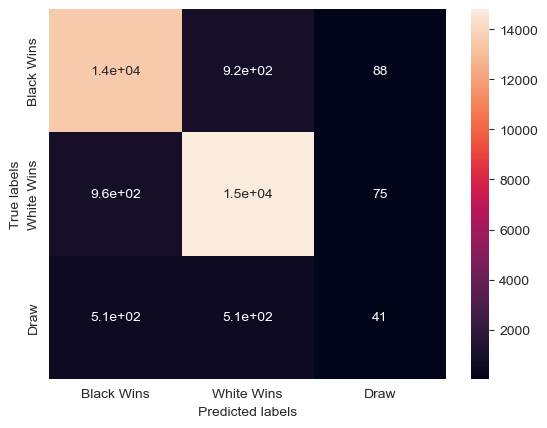

In [185]:
# visualize confusion matrix with sns heatmap
ax = sns.heatmap(cm_df,annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw']); ax.yaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw'])

## Upsampling Draws

In [186]:
# resample data
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X,y)

In [187]:
# view value counts of resampled data
y_resampled.value_counts()

Result
0    62880
1    62880
2    62880
Name: count, dtype: int64

In [188]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=78)

In [189]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [190]:
# create xgboost instance and train model with training data
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [191]:
# store predictions based on model
predictions = xg_nn.predict(X_test_scaled)

In [192]:
# view accuracy score of model
accuracy_score(y_test, predictions)

0.8722858354537744

In [193]:
# view classification report based on model
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.85      0.85      0.85     15675
  White Wins       0.86      0.89      0.88     15739
        Draw       0.90      0.88      0.89     15746

    accuracy                           0.87     47160
   macro avg       0.87      0.87      0.87     47160
weighted avg       0.87      0.87      0.87     47160



In [194]:
# create confusion matrix based on model
cm_df = pd.DataFrame(confusion_matrix(y_test, predictions))

[Text(0, 0.5, 'Black Wins'), Text(0, 1.5, 'White Wins'), Text(0, 2.5, 'Draw')]

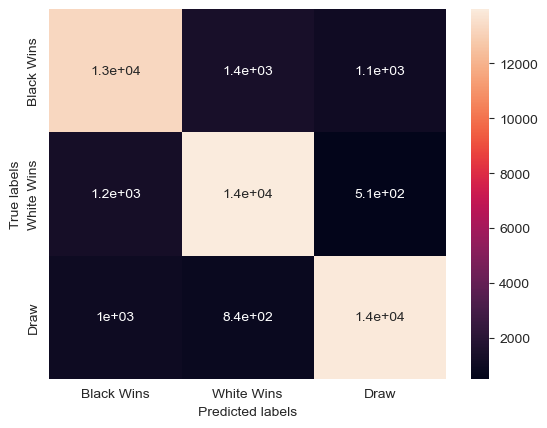

In [195]:
# visualize confusion matrix with heatmap
ax = sns.heatmap(cm_df,annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw']); ax.yaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw'])

## A Purely Predictive Model

In [250]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all,TimeControl,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [251]:
# drop null values
data.dropna(inplace=True)

In [252]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [233]:
# drop features that are not significant or are repeated in other features
data.drop(['WhiteElo','BlackElo','White_count_all','Black_count_all','White_playTime_total','Black_playTime_total'],axis=1,inplace=True)

In [253]:
# Binning data
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

In [254]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [255]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [256]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [257]:
# create xgboost instance and train model with training data
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [258]:
# store predictions based on model
predictions = xg_nn.predict(X_test_scaled)

In [259]:
# view model's accuracy score
accuracy_score(y_test, predictions)

0.5569205308551606

In [260]:
# view classification report based on model
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.54      0.54      0.54     14516
  White Wins       0.57      0.61      0.59     15841
        Draw       0.08      0.00      0.00      1064

    accuracy                           0.56     31421
   macro avg       0.40      0.38      0.38     31421
weighted avg       0.54      0.56      0.55     31421



In [145]:
# create confusion matrix based on model
cm_df = pd.DataFrame(confusion_matrix(y_test, predictions,))

[Text(0, 0.5, 'Black Wins'), Text(0, 1.5, 'White Wins'), Text(0, 2.5, 'Draw')]

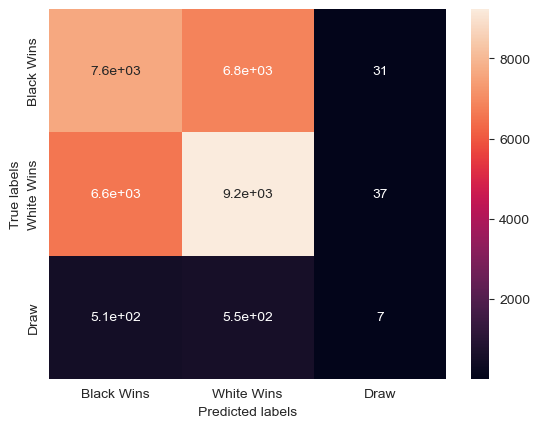

In [146]:
# view confusion matrix with heatmap
ax = sns.heatmap(cm_df,annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw']); ax.yaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw'])

In [261]:
# resample data
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X,y)

In [262]:
# view value counts of resampled data
y_resampled.value_counts()

Result
0    62880
1    62880
2    62880
Name: count, dtype: int64

In [263]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=78)

In [264]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [265]:
# create instance of xgboost and train model with training data
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [266]:
# store predictions based on model
predictions = xg_nn.predict(X_test_scaled)

In [267]:
# view model's accuracy score
accuracy_score(y_test, predictions)

0.6887616624257845

In [268]:
# view classification report based on model
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.56      0.53      0.54     15675
  White Wins       0.57      0.61      0.59     15739
        Draw       0.94      0.93      0.93     15746

    accuracy                           0.69     47160
   macro avg       0.69      0.69      0.69     47160
weighted avg       0.69      0.69      0.69     47160



In [406]:
# create confusion matrix based on model
cm_df = pd.DataFrame(confusion_matrix(y_test, predictions))

[Text(0, 0.5, 'Black Wins'), Text(0, 1.5, 'White Wins'), Text(0, 2.5, 'Draw')]

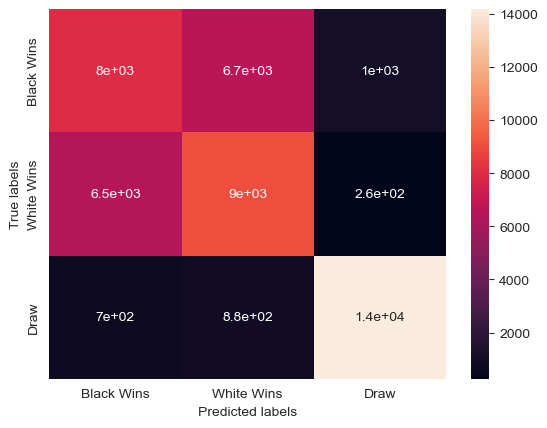

In [407]:
# visualize confusion matrix with heatmap
ax = sns.heatmap(cm_df,annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw']); ax.yaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw'])

## Adding in More Features

In [512]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all,TotalMoves,Termination,TimeControl,ECO,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [513]:
# drop null values
data.dropna(inplace=True)

In [514]:
# create time control feature
data['TimeControl'] = data['TimeControl'].str.split('+').str[0]

In [515]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [516]:
# Binning data
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

In [517]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [518]:
# resample data
X_resampled, y_resampled = smote.fit_resample(X,y)

In [519]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=78)

In [520]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [521]:
# create xgboost instance and train model with training data
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [522]:
# store predictions based on model
predictions = xg_nn.predict(X_test_scaled)

In [523]:
# view accuracy score from model
accuracy_score(y_test, predictions)

0.9090754877014419

In [524]:
# view classification report based on model
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.89      0.88      0.88     15675
  White Wins       0.89      0.91      0.90     15739
        Draw       0.95      0.93      0.94     15746

    accuracy                           0.91     47160
   macro avg       0.91      0.91      0.91     47160
weighted avg       0.91      0.91      0.91     47160



In [525]:
# create dataframe of feature importances from xgboost model
pd.DataFrame({'Feature Name':X.columns,'Importances':xg_nn.feature_importances_}).sort_values(by='Importances',ascending=False).head(50)

,Feature Name,Importances
12,Termination_Normal,0.029857
434,ECO_E05,0.021542
420,ECO_D89,0.018009
448,ECO_E19,0.016595
78,ECO_A23,0.014618
463,ECO_E35,0.012760
104,ECO_A49,0.012564
114,ECO_A59,0.012413
6,TotalMoves,0.010033
338,ECO_C99,0.009821


## Predicting Games Outside the Dataset

In [526]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all,TotalMoves,Termination,TimeControl,ECO,
Result from chess
WHERE Result != '*'
'''
).toPandas()
# drop null values
data.dropna(inplace=True)

In [527]:
# Game 1 link: https://lichess.org/E9bxPZ75
WhiteElo = 1295
BlackElo = 1328
TotalMoves = 35
WhiteGames = 2385
WhiteTime = 14*60 + 16*60*60 + 7*24*60*60
BlackGames = 500
BlackTime = 18*60 + 1*60*60 + 2*24*60*60
TimeControl = '180+0'
Termination = 'Time forfeit'
ECO = 'C23'
Result = '1-0'
datapoint = [WhiteElo,WhiteTime,WhiteGames,BlackElo,BlackTime,BlackGames,TotalMoves,Termination,TimeControl,ECO,Result]
data.loc[len(data)] = datapoint

In [528]:
data['TimeControl'] = data['TimeControl'].str.split('+').str[0]

In [529]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [530]:
# Binning data
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

In [531]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [532]:
game = X.loc[len(X)]
game_result = y.loc[len(y)]

In [533]:
game_scaled = scaler.transform([game])

c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [534]:
print(xg_nn.predict(game_scaled))
print([game_result])

[1]
[1]


## Game 2

In [535]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all,TotalMoves,Termination,TimeControl,ECO,
Result from chess
WHERE Result != '*'
'''
).toPandas()
# drop null values
data.dropna(inplace=True)

In [536]:
# Game 2 link: https://lichess.org/Xs01JCEp
WhiteElo = 1752
BlackElo = 1675
TotalMoves = 33
WhiteGames = 1081
WhiteTime = 56*60 + 19*60*60 + 6*24*60*60
BlackGames = 4057
BlackTime = 48*60 + 12*60*60 + 30*24*60*60
TimeControl = '300+3'
Termination = 'Normal'
ECO = 'B10'
Result = '1-0'
datapoint = [WhiteElo,WhiteTime,WhiteGames,BlackElo,BlackTime,BlackGames,TotalMoves,Termination,TimeControl,ECO,Result]
data.loc[len(data)] = datapoint

In [537]:
data['TimeControl'] = data['TimeControl'].str.split('+').str[0]

In [538]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [539]:
# Binning data
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

In [540]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [541]:
game = X.loc[len(X)]
game_result = y.loc[len(y)]

In [542]:
game_scaled = scaler.transform([game])

c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [543]:
print(xg_nn.predict(game_scaled))
print([game_result])

[1]
[1]


## Game 3

In [544]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all,TotalMoves,Termination,TimeControl,ECO,
Result from chess
WHERE Result != '*'
'''
).toPandas()
# drop null values
data.dropna(inplace=True)

In [545]:
# Game 3 link: https://lichess.org/MapelZMJ
WhiteElo = 1774
BlackElo = 1912
TotalMoves = 30
WhiteGames = 42850
WhiteTime = 12*60 + 9*60*60 + 263*24*60*60
BlackGames = 16522
BlackTime = 39*60 + 2*60*60 + 44*24*60*60
TimeControl = '600+0'
Termination = 'Normal'
ECO = 'C50'
Result = '0-1'
datapoint = [WhiteElo,WhiteTime,WhiteGames,BlackElo,BlackTime,BlackGames,TotalMoves,Termination,TimeControl,ECO,Result]
data.loc[len(data)] = datapoint

In [546]:
data['TimeControl'] = data['TimeControl'].str.split('+').str[0]

In [547]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [548]:
# Binning data
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

In [549]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [550]:
game = X.loc[len(X)]
game_result = y.loc[len(y)]

In [551]:
game_scaled = scaler.transform([game])

c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [552]:
print(xg_nn.predict(game_scaled))
print([game_result])

[0]
[0]


## Game 4

In [555]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all,TotalMoves,Termination,TimeControl,ECO,
Result from chess
WHERE Result != '*'
'''
).toPandas()
# drop null values
data.dropna(inplace=True)

In [556]:
# Game 4 link: https://lichess.org/w7lkVXHA
WhiteElo = 1145
BlackElo = 1096
TotalMoves = 37
WhiteGames = 1222
WhiteTime = 33*60 + 8*60*60 + 9*24*60*60
BlackGames = 889
BlackTime = 5*60 + 1*60*60 + 7*24*60*60
TimeControl = '600+5'
Termination = 'Normal'
ECO = 'B20'
Result = '1-0'
datapoint = [WhiteElo,WhiteTime,WhiteGames,BlackElo,BlackTime,BlackGames,TotalMoves,Termination,TimeControl,ECO,Result]
data.loc[len(data)] = datapoint

In [557]:
data['TimeControl'] = data['TimeControl'].str.split('+').str[0]

In [558]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [559]:
# Binning data
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

In [560]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [561]:
game = X.loc[len(X)]
game_result = y.loc[len(y)]

In [562]:
game_scaled = scaler.transform([game])

c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [563]:
print(xg_nn.predict(game_scaled))
print([game_result])

[1]
[1]


## Game 5: Challenge

In [565]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all,TotalMoves,Termination,TimeControl,ECO,
Result from chess
WHERE Result != '*'
'''
).toPandas()
# drop null values
data.dropna(inplace=True)

In [566]:
# Game 5 link: https://lichess.org/uQcCjFAo
WhiteElo = 955
BlackElo = 882
TotalMoves = 38
WhiteGames = 244
WhiteTime = 49*60 + 2*60*60 + 1*24*60*60
BlackGames = 556
BlackTime = 17*60 + 6*60*60 + 4*24*60*60
TimeControl = '60+0'
Termination = 'Normal'
ECO = 'A13'
Result = '1/2-1/2'
datapoint = [WhiteElo,WhiteTime,WhiteGames,BlackElo,BlackTime,BlackGames,TotalMoves,Termination,TimeControl,ECO,Result]
data.loc[len(data)] = datapoint

In [567]:
data['TimeControl'] = data['TimeControl'].str.split('+').str[0]

In [568]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [569]:
# Binning data
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

In [570]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [571]:
game = X.loc[len(X)]
game_result = y.loc[len(y)]

In [572]:
game_scaled = scaler.transform([game])

c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [573]:
print(xg_nn.predict(game_scaled))
print([game_result])

[0]
[2]
